In [1]:
#Libraries
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import time
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Links 

In [ ]:
driver = webdriver.Chrome(executable_path=r'C:\chromedriver_win32\chromedriver.exe')
links=[]

for i in range(1,114):
    url='https://www.igb.ie/results/?FromDate=01-Jan-2018&ToDate=01-Sep-2019&stadium=&page={}'.format(i)

    driver.get(url)

    soup=BeautifulSoup(driver.page_source,'lxml')

    content=soup.find('table',class_='igb-tbl')

    
    for x in content.find_all('a'):
        link1=x['href']
        links.append("https://www.igb.ie"+link1)

In [ ]:
len(links)

In [ ]:
links_df=pd.DataFrame(np.zeros(2822).reshape((2822,1)),columns=['Links'])
links_df['Links']=links
links_df.to_csv('Links_County.csv')

In [2]:
links_df=pd.read_csv('links_county.csv')

links=[]
for i in range(len(links_df)):
    links.append(links_df['Links'][i])

In [3]:
len(links)

2822

# Scraping Data from tables

In [6]:
data=[]
link1=[]
race_name_temp=[]
race_name=[]
e=0

for s in range(len(links)):
    res=requests.get(links[s])
    soup=BeautifulSoup(res.text)
    
    for i in soup.select('body div.body-lock section.strip div div div div.col-12.col-offset-1.t-header div div div.clearfix div:nth-child(5)'):
        
        for k in i.find_all('div',class_='col-13'):
            race_name_temp.append(k.text.strip())
            
        for j in i.find_all('table',class_='igb-tbl'):
            try:
                a=j.find_all('tr')[1]
                z=a.find_all('td')
                row=[w.text for w in z]
                race_name.append(race_name_temp[e])
                data.append(row)
                link1.append(links[s])
                e=e+1
            except IndexError:
                e=e+1
                break
        e=0
        race_name_temp=[]

In [7]:
len(data),len(race_name),len(link1)

(28783, 28783, 28783)

In [289]:
with open("./Ireland Data/data.txt", "wb") as fp:
    pickle.dump(data, fp)

with open("./Ireland Data/race_name.txt", "wb") as fp:
    pickle.dump(race_name, fp)
    
with open("./Ireland Data/links.txt", "wb") as fp:
    pickle.dump(link1, fp)

In [184]:
with open("./Ireland Data/data.txt", "rb") as fp:
    data = pickle.load(fp)
with open("./Ireland Data/race_name.txt", "rb") as fp:
    race_name = pickle.load(fp)
with open("./Ireland Data/links.txt", "rb") as fp:
    link1 = pickle.load(fp)

# Data Pre-Processing and cleaning

In [185]:
df=pd.DataFrame(data)
Race_Name=pd.DataFrame(race_name)
Links_1=pd.DataFrame(link1)

In [186]:
df.columns=['Position','Trap','Greyhound','Sire Name','Dam Name','Prize','WT.','Win Time','By',
            'Going','EST Time','SP','Grade','Comm.']

In [187]:
df['Race Name']=Race_Name[0]
df['Link']=Links_1

In [188]:
df['Date']=df['Link'].apply(lambda x:x[56:])
df['County']=df['Link'].apply(lambda x:x[47:50])
df['Distance']=df['Race Name'].apply(lambda x:x[-3:])
df['EST Time']=df['EST Time'].apply(lambda x:x[:5])
df['Prize']=df['Prize'].replace({'€':''}, regex=True)

In [189]:
def z(s):
    if(s=='SPK'):
        return('Shelbourne Park')
    elif(s=='TRL'):
        return('Tralee')
    elif(s=='LMK'):
        return('Limerick')
    elif(s=='CRK'):
        return('Curraheen Park')
    elif(s=='YGL'):
        return('YOUGHAL')
    elif(s=='MGR'):
        return('MULLINGAR')
    elif(s=='DLK'):
        return('Dundalk')
    elif(s=='GLY'):
        return('GALWAY')
    elif(s=='WFD'):
        return('WATERFORD')
    elif(s=='CML'):
        return('CLONMEL')
    elif(s=='KKY'):
        return('KILKENNY')
    elif(s=='ECY'):
        return('ENNISCORTHY')
    elif(s=='LGD'):
        return('LONGFORD')
    elif(s=='DBP'):
        return('DRUMBO PARK')
    elif(s=='LFD'):
        return('LIFFORD')
    elif(s=='NWB'):
        return('NEWBRIDGE')
    elif(s=='THR'):
        return('THURLES PARK')
    elif(s=='DRY'):
        return('DERRY')
    else:
        return('Not Mentioned')
    
df['County']=df['County'].apply(z)

In [190]:
df['SP'] = df['SP'].str.replace(r'[^\d.]+', '')
df['SP'][df['SP']==""]='01'
for i in range(len(df)):
    if(len(df['SP'][i])==2):
        a=df['SP'][i]
        q,w=a[0],a[1]
        q=float(q)
        w=float(w)
        try:
            c=q/w
        except ZeroDivisionError:
            c=0
        df['SP'][i]=c
    else:
        df['SP'][i]=0

In [191]:
df=df[df['EST Time']!='-']
df=df[df['SP']!=0]

Rejection: 7 points
z_score of 5 corresponds to prob of 0.00%


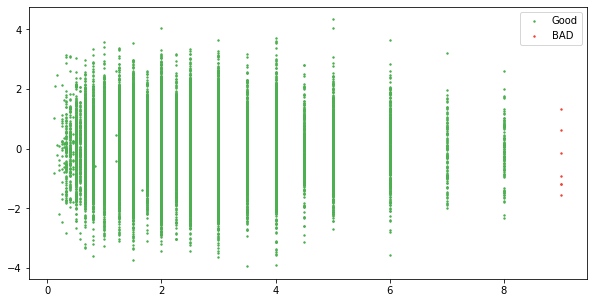

In [318]:
data=df
#Outliers Detection
mean,std=np.mean(data['SP']),np.std(data['SP'])
z_score=np.abs((data['SP']-mean)/std)
threshold=5
good=z_score<threshold
print(f'Rejection: {(~good).sum()} points')

from scipy.stats import norm
print(f"z_score of 5 corresponds to prob of {100*2*norm.sf(threshold):0.2f}%")
visual_scatter=np.random.normal(size=data['SP'].size)

plt.figure(figsize=(10,5))
plt.scatter(data['SP'][good],visual_scatter[good],s=2,label='Good',color='#4CAF50')
plt.scatter(data['SP'][~good],visual_scatter[~good],s=2,label='BAD',color='#F44336')
plt.legend()

Rejection: 7 points
z_score of 6 corresponds to prob of 0.00%


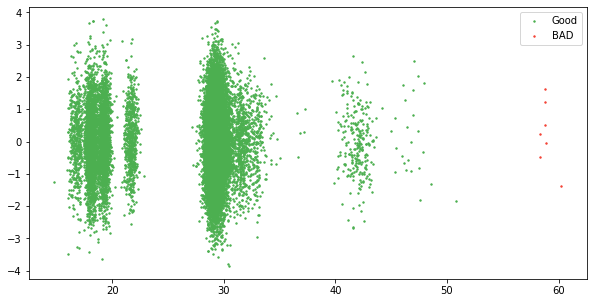

In [320]:
data=df
#Outliers Detection
mean,std=np.mean(data['EST Time']),np.std(data['EST Time'])
z_score=np.abs((data['EST Time']-mean)/std)
threshold=6
good=z_score<threshold
print(f'Rejection: {(~good).sum()} points')

from scipy.stats import norm
print(f"z_score of 6 corresponds to prob of {100*2*norm.sf(threshold):0.2f}%")
visual_scatter=np.random.normal(size=data['EST Time'].size)

plt.figure(figsize=(10,5))
plt.scatter(data['EST Time'][good],visual_scatter[good],s=2,label='Good',color='#4CAF50')
plt.scatter(data['EST Time'][~good],visual_scatter[~good],s=2,label='BAD',color='#F44336')
plt.legend()

Rejection: 16 points
z_score of 3 corresponds to prob of 0.27%


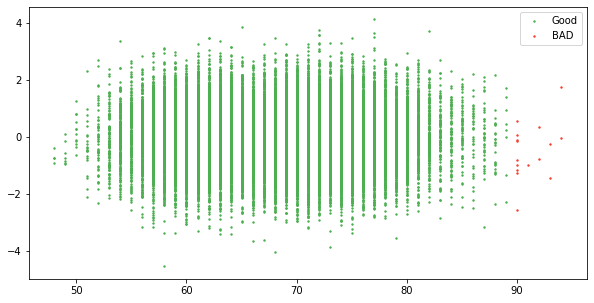

In [333]:
data=df
#Outliers Detection
mean,std=np.mean(data['WT.']),np.std(data['WT.'])
z_score=np.abs((data['WT.']-mean)/std)
threshold=3
good=z_score<threshold
print(f'Rejection: {(~good).sum()} points')

from scipy.stats import norm
print(f"z_score of 3 corresponds to prob of {100*2*norm.sf(threshold):0.2f}%")
visual_scatter=np.random.normal(size=data['WT.'].size)

plt.figure(figsize=(10,5))
plt.scatter(data['WT.'][good],visual_scatter[good],s=2,label='Good',color='#4CAF50')
plt.scatter(data['WT.'][~good],visual_scatter[~good],s=2,label='BAD',color='#F44336')
plt.legend()

Rejection: 138 points
z_score of 3 corresponds to prob of 0.27%


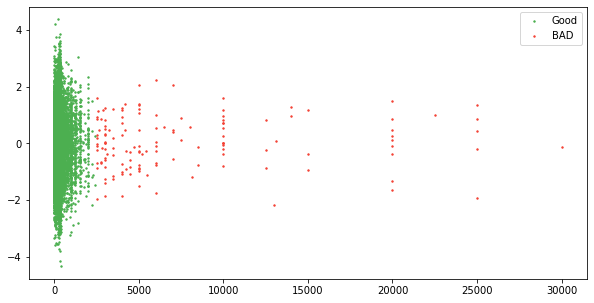

In [334]:
data=df
#Outliers Detection
mean,std=np.mean(data['Prize']),np.std(data['Prize'])
z_score=np.abs((data['Prize']-mean)/std)
threshold=3
good=z_score<threshold
print(f'Rejection: {(~good).sum()} points')

from scipy.stats import norm
print(f"z_score of 3 corresponds to prob of {100*2*norm.sf(threshold):0.2f}%")
visual_scatter=np.random.normal(size=data['Prize'].size)

plt.figure(figsize=(10,5))
plt.scatter(data['Prize'][good],visual_scatter[good],s=2,label='Good',color='#4CAF50')
plt.scatter(data['Prize'][~good],visual_scatter[~good],s=2,label='BAD',color='#F44336')
plt.legend()

In [299]:
df['Distance']=df['Distance'].astype(float)
df['Prize']=df['Prize'].astype(float)
df['WT.']=df['WT.'].astype(float)
df['Win Time']=df['Win Time'].astype(float)
df['EST Time']=df['EST Time'].astype(float)
df['SP']=df['SP'].astype(float)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [ ]:
df=df[df['Prize']<5000]
df=df[df['SP']<8]
df=df[df['EST Time']<55]

In [300]:
df.to_csv('./Ireland Data/Final_Data.csv')

# Analysis

In [343]:
df.describe()

,Prize,WT.,Win Time,EST Time,SP,Distance
count,27109.000000,27109.000000,27109.00000,27109.000000,27109.000000,27109.000000
mean,269.415797,68.217935,27.56805,27.448922,2.323613,494.364233
std,251.961914,7.094720,4.55169,4.504462,1.188371,79.270090
min,0.000000,48.000000,14.82000,14.820000,0.125000,25.000000
25%,150.000000,62.000000,28.65000,28.650000,1.500000,525.000000
50%,285.000000,69.000000,29.23000,29.120000,2.000000,525.000000
75%,325.000000,74.000000,29.68000,29.460000,3.000000,525.000000
max,4700.000000,94.000000,60.22000,60.220000,7.000000,900.000000


In [303]:
df['County'].value_counts()

Shelbourne Park    3546
Tralee             3047
Limerick           1947
Curraheen Park     1941
MULLINGAR          1763
YOUGHAL            1607
GALWAY             1540
Dundalk            1525
WATERFORD          1489
KILKENNY           1349
ENNISCORTHY        1224
CLONMEL            1097
LONGFORD           1076
DRUMBO PARK         981
LIFFORD             933
NEWBRIDGE           888
THURLES PARK        795
DERRY               551
Name: County, dtype: int64

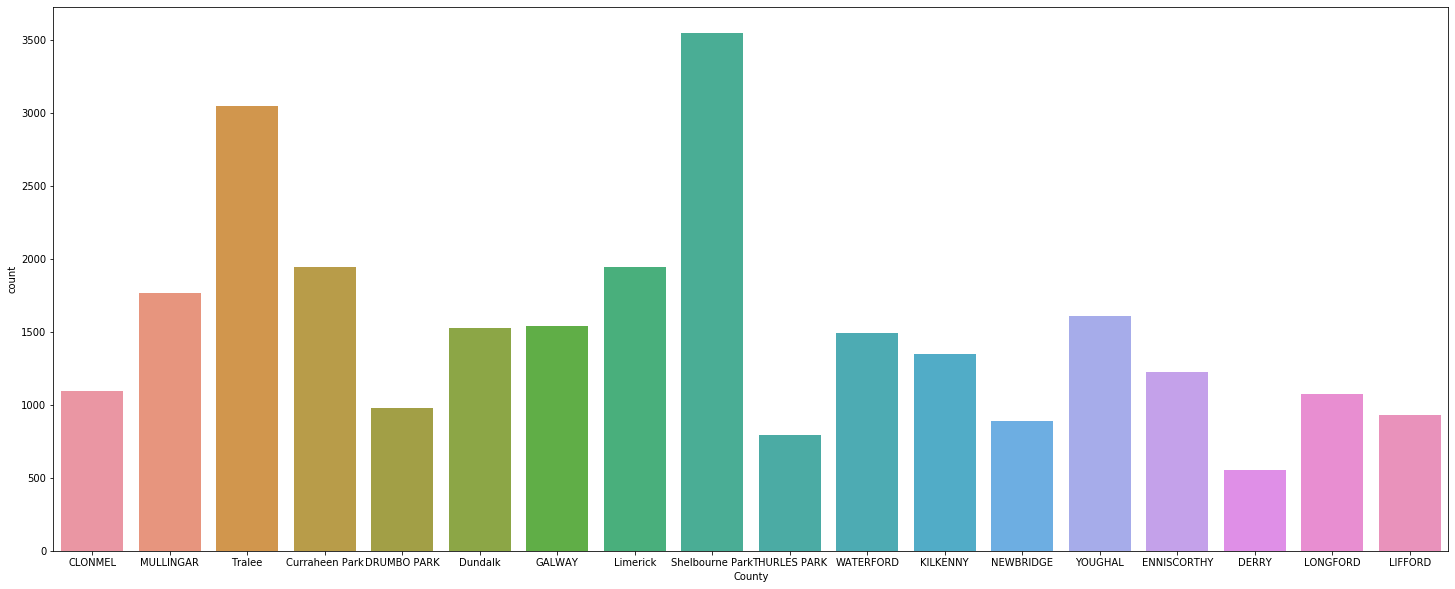

In [304]:
#County With most appearances
plt.figure(figsize=(25,10))
sns.countplot(df['County'])

In [367]:
#Fastest Greyhound overall 
fastest_greyhound_wins=df.loc[:,['County','Greyhound','Sire Name','Dam Name','Win Time','EST Time']].sort_values('Win Time').reset_index().drop('index',axis=1)
fastest_greyhound_wins.head(30)

,County,Greyhound,Sire Name,Dam Name,Win Time,EST Time
0,DERRY,RAG DOLLY MOLLY,GODSEND,TYRUR LATOYA,14.82,14.82
1,CLONMEL,GONE TO GROUND,SUPERIOR PRODUCT,LAUGHIL LUCY,15.95,15.95
2,CLONMEL,GONE TO GROUND,SUPERIOR PRODUCT,LAUGHIL LUCY,16.03,16.03
3,CLONMEL,BRYNOFFA CINDY,SHANEBOY LEE,EMMA HONEY,16.05,16.05
4,CLONMEL,PIEMANS DART,SCOLARI ME DADDY,CASTLE SPIRIT,16.05,16.05
5,CLONMEL,KNOCKDUFF DECLAN,ROMEO RECRUIT,WHITEYS JEWEL,16.07,16.07
6,CLONMEL,ROCKYS PRIDE,LAUGHIL BLAKE,BALLYROBIN SABLE,16.08,16.08
7,CLONMEL,BRYNOFFA SPY,HOLDEM SPY,EMMA HONEY,16.09,16.09
8,CLONMEL,TIVOLI ROSE,LAUGHIL BLAKE,TIVOLI MAEVE,16.09,16.09
9,CLONMEL,ART OF SPEED,TYRUR BIG MIKE,LAUGHIL LIZ,16.11,16.01


In [355]:
#Fastest Greyhound Top 500
fastest_greyhound_wins_5000=fastest_greyhound_wins[:5000]
fastest_greyhound_wins.head(10)

,County,Greyhound,Sire Name,Dam Name,Win Time,EST Time
0,DERRY,RAG DOLLY MOLLY,GODSEND,TYRUR LATOYA,14.82,14.82
1,CLONMEL,GONE TO GROUND,SUPERIOR PRODUCT,LAUGHIL LUCY,15.95,15.95
2,CLONMEL,GONE TO GROUND,SUPERIOR PRODUCT,LAUGHIL LUCY,16.03,16.03
3,CLONMEL,BRYNOFFA CINDY,SHANEBOY LEE,EMMA HONEY,16.05,16.05
4,CLONMEL,PIEMANS DART,SCOLARI ME DADDY,CASTLE SPIRIT,16.05,16.05
5,CLONMEL,KNOCKDUFF DECLAN,ROMEO RECRUIT,WHITEYS JEWEL,16.07,16.07
6,CLONMEL,ROCKYS PRIDE,LAUGHIL BLAKE,BALLYROBIN SABLE,16.08,16.08
7,CLONMEL,BRYNOFFA SPY,HOLDEM SPY,EMMA HONEY,16.09,16.09
8,CLONMEL,TIVOLI ROSE,LAUGHIL BLAKE,TIVOLI MAEVE,16.09,16.09
9,CLONMEL,ART OF SPEED,TYRUR BIG MIKE,LAUGHIL LIZ,16.11,16.01


In [354]:
fastest_greyhound_wins_5000['County'].value_counts()

Tralee             526
DRUMBO PARK        517
Dundalk            501
LIFFORD            467
GALWAY             462
LONGFORD           455
Curraheen Park     341
Limerick           332
DERRY              273
Shelbourne Park    220
CLONMEL            200
NEWBRIDGE          196
MULLINGAR          171
YOUGHAL            110
THURLES PARK        98
ENNISCORTHY         71
KILKENNY            32
WATERFORD           28
Name: County, dtype: int64

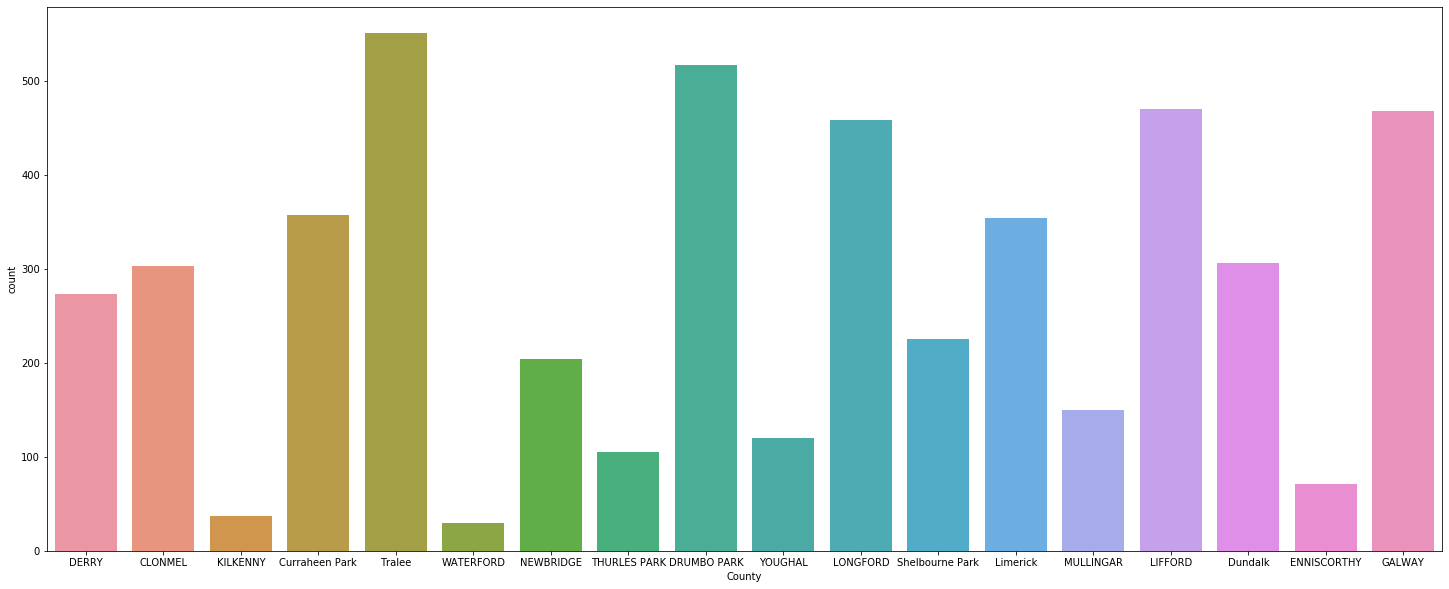

In [248]:
plt.figure(figsize=(25,10))
sns.countplot(fastest_greyhound_wins_500['County'])

In [353]:
#Number of Greyhound to fast greyhound ratio
a=fastest_greyhound_wins_5000['County'].value_counts()
b=df['County'].value_counts()
c=(a/b).sort_values(ascending=False)
c

DRUMBO PARK        0.527013
LIFFORD            0.501073
DERRY              0.496364
LONGFORD           0.423650
Dundalk            0.329605
GALWAY             0.300390
NEWBRIDGE          0.221469
CLONMEL            0.183150
Curraheen Park     0.177051
Tralee             0.174115
Limerick           0.171665
THURLES PARK       0.123737
MULLINGAR          0.097882
YOUGHAL            0.069095
Shelbourne Park    0.063218
ENNISCORTHY        0.058101
KILKENNY           0.023970
WATERFORD          0.018893
Name: County, dtype: float64

In [261]:
#County's Greyhound with best winning time
best_winning_county_overall=df.groupby('County')['Win Time'].mean()
best_winning_county_overall=best_winning_county.sort_values()
best_winning_county

County
DERRY              22.936709
DRUMBO PARK        23.495617
LIFFORD            24.666791
LONGFORD           25.093432
Dundalk            25.878250
GALWAY             26.552773
CLONMEL            26.963771
NEWBRIDGE          26.979120
Tralee             27.376692
Curraheen Park     27.397914
Limerick           27.817803
THURLES PARK       28.470059
MULLINGAR          28.862806
Shelbourne Park    28.910722
YOUGHAL            28.951869
WATERFORD          29.118526
ENNISCORTHY        29.377437
KILKENNY           29.859127
Name: Win Time, dtype: float64

In [357]:
#County with highest prize money earning
highest_earning_county=df.groupby('County')['Prize'].sum()
highest_earning_county=highest_earning_county.sort_values(ascending=False)
highest_earning_county

County
Shelbourne Park    1189070.00
Tralee              836852.50
Curraheen Park      568315.00
Limerick            561607.50
YOUGHAL             472772.50
MULLINGAR           466870.00
WATERFORD           431536.00
GALWAY              417317.50
Dundalk             397973.50
KILKENNY            368960.00
ENNISCORTHY         351270.00
CLONMEL             290995.00
LONGFORD            256007.50
LIFFORD             237933.33
NEWBRIDGE           229127.50
THURLES PARK        226015.00
DERRY                   70.00
DRUMBO PARK              0.00
Name: Prize, dtype: float64

In [414]:
highest_earning_county/df['County'].value_counts()

CLONMEL            266.478938
Curraheen Park     295.075286
DERRY                0.127273
DRUMBO PARK          0.000000
Dundalk            261.824671
ENNISCORTHY        287.454992
GALWAY             271.337776
KILKENNY           276.374532
LIFFORD            255.293273
LONGFORD           238.368250
Limerick           290.386505
MULLINGAR          267.240985
NEWBRIDGE          258.901130
Shelbourne Park    341.686782
THURLES PARK       285.372475
Tralee             277.011751
WATERFORD          291.184885
YOUGHAL            296.967651
dtype: float64

In [362]:
#greyhound with best win time average-Top 500
best_winning_greyhounds_500=df.groupby('Greyhound')['Win Time'].mean()[:500]
best_winning_greyhounds_500=best_winning_greyhounds_500.sort_values()
best_winning_greyhounds_500[:10]

Greyhound
ART OF SPEED        16.110000
ARCHGROVE JOSIE     16.285000
ASTONS SUPREME      16.423333
ASSARULA JACK       16.450000
ASTONS BELLE        16.450000
AN CHARRAIG ABU     16.540000
ARCHGROVE RANGER    16.570000
ARCHGROVE ROGER     16.590000
ARCHGROVE RONNIE    16.626667
ABBYLEA ROCKET      16.640000
Name: Win Time, dtype: float64

In [364]:
#County with best winning odds
best_winning_odds_county=df.groupby('County')['SP'].mean()
best_winning_odds.sort_values(ascending=False)

County
YOUGHAL            2.624698
KILKENNY           2.448507
Shelbourne Park    2.409314
ENNISCORTHY        2.387740
Limerick           2.382391
LIFFORD            2.345956
Tralee             2.335320
Curraheen Park     2.309809
MULLINGAR          2.296792
WATERFORD          2.264420
DRUMBO PARK        2.199988
THURLES PARK       2.032361
GALWAY             1.998282
Dundalk            1.993272
DERRY              1.960157
LONGFORD           1.879380
NEWBRIDGE          1.823020
CLONMEL            1.415979
Name: SP, dtype: float64

In [366]:
#Greyhounds with most distance covered
max_distance_greyhounds_500=df.groupby('Greyhound')['Distance'].sum()[:500]
max_distance_greyhounds_500=max_distance_greyhounds_500.sort_values()
max_distance_greyhounds_500[max_distance_greyhounds_500>5000].sort_values(ascending=False)

Greyhound
ARDERA BONUS        8950.0
ANASCAUL BLACKIE    6825.0
ABBEYVILLE OSCAR    6825.0
ABINGTON HERO       6350.0
ANYTIME JOE         6300.0
ANASCAUL JIMMY      5775.0
ABBEYVILLE CIAN     5250.0
ABBEYVILLE ISE      5250.0
ADAMANT BROOKS      5250.0
AIRFIELD HARRY      5250.0
ARDRATH ALFRED      5250.0
Name: Distance, dtype: float64

In [411]:
#Greyhounds with most appearance
max_race_greyhounds_500=df['Greyhound'].value_counts()
a=max_race_greyhounds_500[:200]
a

SLANEYSIDE KEYES    20
SLIPPY CIAN         18
ARDERA BONUS        17
TOKENFIRE ABBIE     17
SMURFING SEASON     17
                    ..
TRUMERA QUARRY      10
SUNNY SIMONE        10
OUR JIM             10
ADAMANT BROOKS      10
DOWDINGSTOWN BOY    10
Name: Greyhound, Length: 200, dtype: int64

In [412]:
a=a.index.values
a=list(a)
df3=df[df["Greyhound"].isin(a)]
ad=df3.groupby('Greyhound')['Win Time'].mean()
ad=ad.sort_values()
ad

Greyhound
KNOCKALTON GUY      17.836000
SLANEYSIDE KEYES    17.949500
SNIPERSBLACKLIST    18.260667
BUTTERBRIDGE BEX    18.375455
MONPARK JACK        18.844000
                      ...    
CUSHIE JET          31.770714
SMURFING SEASON     32.091176
WANGANUI            32.253000
BE SLOW DJANGO      32.468000
SKYWALKER LOGAN     32.887692
Name: Win Time, Length: 200, dtype: float64

# Data Preparation for ANN

In [11]:
col=['County','Distance','Prize','WT.','Win Time','EST Time','SP','Grade']
df2=df[col]

In [12]:
df2.head()

,County,Distance,Prize,WT.,Win Time,EST Time,SP,Grade
0,CLONMEL,525,310.00,59,29.34,29.14,1.5,A3
1,CLONMEL,525,310.00,65,29.35,29.15,1.5,A3
2,CLONMEL,300,210.00,68,16.59,16.59,1.5,S3
3,CLONMEL,525,325.00,74,29.09,28.89,1.75,A1
4,CLONMEL,525,325.00,66,29.00,28.80,2.5,A1


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28783 entries, 0 to 28782
Data columns (total 8 columns):
County      28783 non-null object
Distance    28783 non-null object
Prize       28783 non-null object
WT.         28783 non-null object
Win Time    28783 non-null object
EST Time    28783 non-null object
SP          28783 non-null object
Grade       28783 non-null object
dtypes: object(8)
memory usage: 1.8+ MB


In [14]:
df2['EST Time'][22262]=0

C:\Users\asus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
df2['Distance']=df2['Distance'].astype(float)
df2['Prize']=df2['Prize'].astype(float)
df2['WT.']=df2['WT.'].astype(float)
df2['Win Time']=df2['Win Time'].astype(float)
df2['EST Time']=df2['EST Time'].astype(float)
df2['SP']=df2['SP'].astype(float)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2['County'] = le.fit_transform(df2['County'])
df2['Grade'] = le.fit_transform(df2['Grade'])

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
df2.head()

,County,Distance,Prize,WT.,Win Time,EST Time,SP,Grade
0,0,525.0,310.0,59.0,29.34,29.14,1.50,5
1,0,525.0,310.0,65.0,29.35,29.15,1.50,5
2,0,300.0,210.0,68.0,16.59,16.59,1.50,27
3,0,525.0,325.0,74.0,29.09,28.89,1.75,2
4,0,525.0,325.0,66.0,29.00,28.80,2.50,2


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28783 entries, 0 to 28782
Data columns (total 8 columns):
County      28783 non-null int32
Distance    28783 non-null float64
Prize       28783 non-null float64
WT.         28783 non-null float64
Win Time    28783 non-null float64
EST Time    28783 non-null float64
SP          28783 non-null float64
Grade       28783 non-null int32
dtypes: float64(6), int32(2)
memory usage: 1.5 MB


In [19]:
df2.corr()

,County,Distance,Prize,WT.,Win Time,EST Time,SP,Grade
County,1.000000,0.166492,0.028178,-0.010562,0.170618,0.165154,0.108953,-0.176974
Distance,0.166492,1.000000,0.053232,-0.035936,0.969001,0.975665,0.084932,-0.861301
Prize,0.028178,0.053232,1.000000,0.021456,0.044764,0.045890,0.017024,-0.028479
WT.,-0.010562,-0.035936,0.021456,1.000000,-0.062434,-0.057849,-0.058432,0.025681
Win Time,0.170618,0.969001,0.044764,-0.062434,1.000000,0.990569,0.087000,-0.841571
EST Time,0.165154,0.975665,0.045890,-0.057849,0.990569,1.000000,0.087824,-0.846300
SP,0.108953,0.084932,0.017024,-0.058432,0.087000,0.087824,1.000000,-0.085394
Grade,-0.176974,-0.861301,-0.028479,0.025681,-0.841571,-0.846300,-0.085394,1.000000


In [20]:
train=df2.drop('EST Time',axis=1)
test=df2['EST Time']

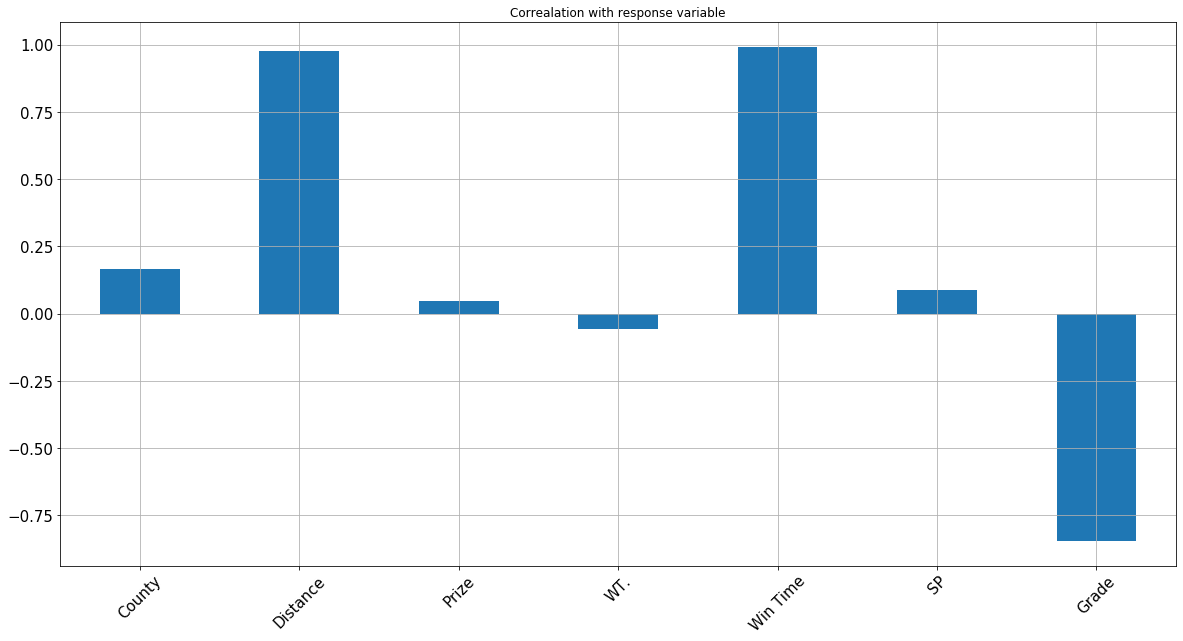

In [21]:
train.corrwith(test).plot.bar(figsize=(20,10),
                                           title="Correalation with response variable",
                                           fontsize=15,rot=45,grid=True)

In [22]:
from sklearn.preprocessing import StandardScaler
train_norm=StandardScaler().fit_transform(train)

In [23]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_norm,test,test_size=0.3,random_state=0)

In [24]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((20148, 7), (20148,), (8635, 7), (8635,))

In [25]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# ANN Implementation

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [27]:
model=Sequential([
    Dense(units=16,input_dim=7,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(units=1,activation='linear')
])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',loss='mean_absolute_error',metrics=["mean_absolute_error"])
history=model.fit(x_train,y_train,batch_size=15,epochs=20,validation_split=0.3)

Train on 14103 samples, validate on 6045 samples
Epoch 1/20
14103/14103 [==============================] - 3s 202us/step - loss: 6.9504 - mean_absolute_error: 6.9504 - val_loss: 1.3114 - val_mean_absolute_error: 1.3114
Epoch 2/20
14103/14103 [==============================] - 4s 261us/step - loss: 0.7092 - mean_absolute_error: 0.7092 - val_loss: 0.3718 - val_mean_absolute_error: 0.3718
Epoch 3/20
14103/14103 [==============================] - 4s 295us/step - loss: 0.2792 - mean_absolute_error: 0.2792 - val_loss: 0.2290 - val_mean_absolute_error: 0.2290
Epoch 4/20
14103/14103 [==============================] - 4s 294us/step - loss: 0.2013 - mean_absolute_error: 0.2013 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750
Epoch 5/20
14103/14103 [==============================] - 4s 293us/step - loss: 0.1736 - mean_absolute_error: 0.1736 - val_loss: 0.1719 - val_mean_absolute_error: 0.1719
Epoch 6/20
14103/14103 [==============================] - 4s 295us/step - loss: 0.1621 - mean_absolut

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


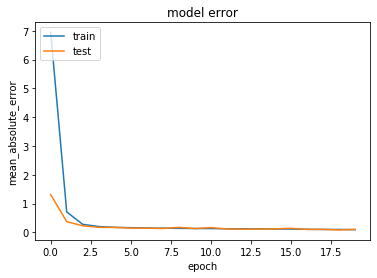

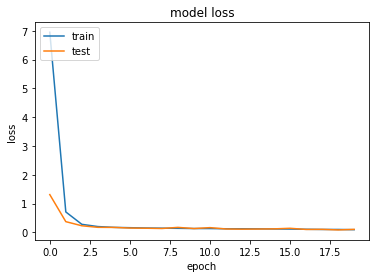

In [30]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
y_pred=model.predict(x_test)

In [32]:
y_pred[1]

array([29.17461], dtype=float32)

In [33]:
y_test[1]

29.0

In [35]:
from sklearn.metrics import mean_squared_error 
mse=mean_squared_error(y_test,y_pred)
mse

0.7718811115699471

# Regressor Algorithms Implementation

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [43]:
alg1=RandomForestRegressor(n_estimators=50,random_state=0,criterion="mse")
alg1.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [44]:
alg2=DecisionTreeRegressor()
alg2.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [45]:
alg3=LinearRegression()
alg3.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
alg4=SVR()
alg4.fit(x_train,y_train)

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
def sc(y_truth,y_pred):
    u=((y_truth-y_pred)**2).sum()
    v=((y_truth-y_truth.mean())**2).sum()
    return 1-(u/v)

In [48]:
#Prediction
y_pred_1=alg1.predict(x_test)
y_pred_2=alg2.predict(x_test)
y_pred_3=alg3.predict(x_test)
y_pred_4=alg4.predict(x_test)

In [51]:
print("Random Forest accuracy:",sc(y_test,y_pred_1))
print("Decesion Tree accuracy:",sc(y_test,y_pred_2))
print("Linear Regression accuracy:",sc(y_test,y_pred_3))
print("SVR:",sc(y_test,y_pred_4))

Random Forest accuracy: 0.9902181939285286
Decesion Tree accuracy: 0.9968439302678005
Linear Regression accuracy: 0.9471586480553077
SVR: 0.9761545732455273


In [53]:
x_test_1=pd.DataFrame(x_test)

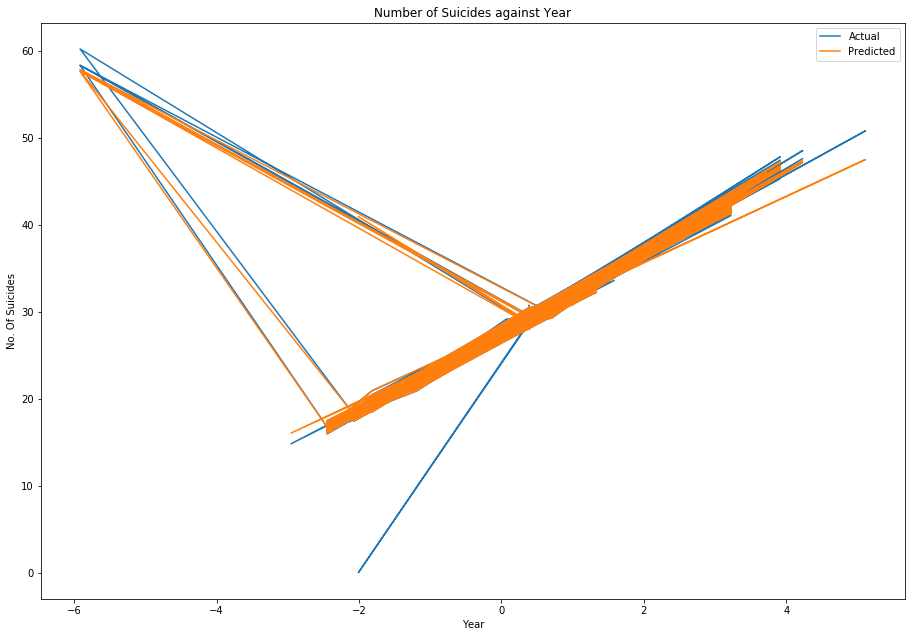

In [58]:
#Plotting of Predicted Data against Actual Data
fig=plt.figure()
ax=fig.add_axes([2,2,2,2])
y=y_test
x=x_test_1[1]
y1=y_pred_1
ax.plot(x,y,label="Actual")
ax.plot(x,y1,label="Predicted")
ax.set_xlabel("Year")
ax.set_ylabel("No. Of Suicides")
ax.set_title("Number of Suicides against Year")
ax.legend()